In [1]:
from glob import glob
import pandas as pd
import numpy as np
import sys
import os
import glob
import pyspawn
import h5py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import Layout, Label
from IPython.display import display
from matplotlib import cm
from pyspawn.plotting import traj_plot
import MDAnalysis as mda
import nglview as nv
from nglview.datafiles import PDB, XTC
from ipywidgets import interact, interact_manual

# Single simulation analysis

Here we create a fafile object that pulls the data from the sim.hdf5 file and outputs the arrays for plotting. 

In [2]:
print "Currently in directory:", os.getcwd()

Currently in directory: /home/fedorovd/cn9n/casscf_2x3_t800


In [3]:
# THIS IS THE ONLY PART OF THE CODE THAT NEEDS TO BE CHANGED
dir_name = "/home/fedorovd/4tce/casscf_dynamics"
h5filename = "sim.hdf5"

In [4]:
os.chdir(dir_name)
an = pyspawn.fafile(h5filename)

an.fill_electronic_state_populations(column_filename="N.dat")
an.fill_labels()
an.fill_istates()
an.get_numstates()

times = an.datasets["quantum_times"]
el_pop = an.datasets["electronic_state_populations"]
istates = an.datasets["istates"]
labels = an.datasets["labels"]
ntraj = len(an.datasets["labels"])
nstates = an.datasets['numstates']
an.fill_nuclear_bf_populations()

# write files with energy data for each trajectory
an.fill_trajectory_energies(column_file_prefix="E")

# write file with time derivative couplings for each trajectory
an.fill_trajectory_tdcs(column_file_prefix="tdc")

# compute Mulliken population of each trajectory
an.fill_mulliken_populations(column_filename="mull.dat")

mull_pop = an.datasets["electronic_state_populations"]

# istates dict
an.create_istate_dict()
istates_dict = an.datasets['istates_dict']

# writing xyz files for visualization
an.write_xyzs()

In [5]:
print labels
print istates

['00']
[1]


Loading the arrays for plotting

In [6]:
arrays = ("poten", "pop", "toten", "aven", "kinen", "time", "tdc")
# creating dictionary for the datasets we want to plot
# keys are trajectory labels
for array in arrays:
    exec(array + "= dict()")

for traj in an.datasets["labels"]:
    
    poten[traj] = an.datasets[traj + "_poten"]
#     pop[traj] = an.datasets[traj + "_pop"]
    toten[traj] = an.datasets[traj + "_toten"]
    kinen[traj] = an.datasets[traj + "_kinen"]
    time[traj] = an.datasets[traj + "_time"]
    tdc[traj] = an.datasets[traj + "_tdc"]

Setting plotting parameters
(Perhaps there is a better way to do it, right now these hardcoded color and styles limit us to 7 electronic states and 16 trajectories. However, one could argue that more lines on a single plot would not be very informative anyway)

In [7]:
colors = ("r", "g", "b", "m", "y", "k", "k")
linestyles = ("-", "--", "-.", ":","-","-","-","-","-","-","-","-","-","-","-","-")
markers=("None","None","None","None","d","o","v","^","s","p","d","o","v","^","s","p")
large_size = 16
medium_size = 14
small_size = 12

This widget picks the trajectories we want to plot in case there are many of them

In [8]:
labels_to_plot_widget = widgets.SelectMultiple(
    options=labels,
    value=['00'],
    rows=10,
    description='Trajectories',
    disabled=False
)

/home/fedorovd/anaconda2/lib/python2.7/site-packages/traitlets/traitlets.py:567: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


In [9]:
display(labels_to_plot_widget)

SelectMultiple(description=u'Trajectories', index=(0,), options=('00',), rows=10, value=('00',))

# Plotting Total Energies

<IPython.core.display.Javascript object>


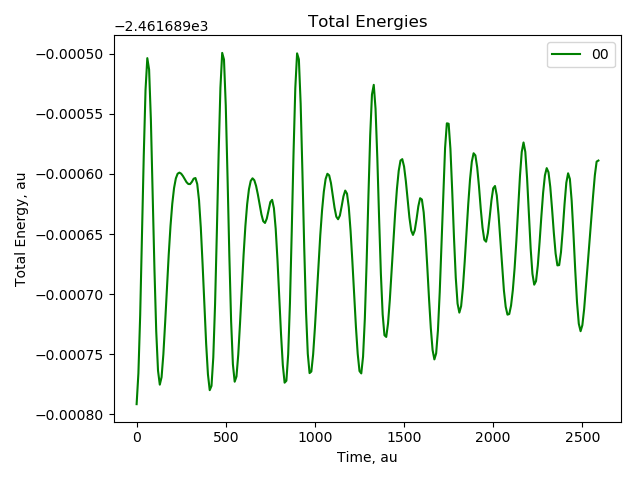

In [10]:
%matplotlib notebook
traj_plot.plot_total_energies(time, toten, labels_to_plot_widget.value, istates_dict, colors, markers, linestyles)

# Total Population

<IPython.core.display.Javascript object>


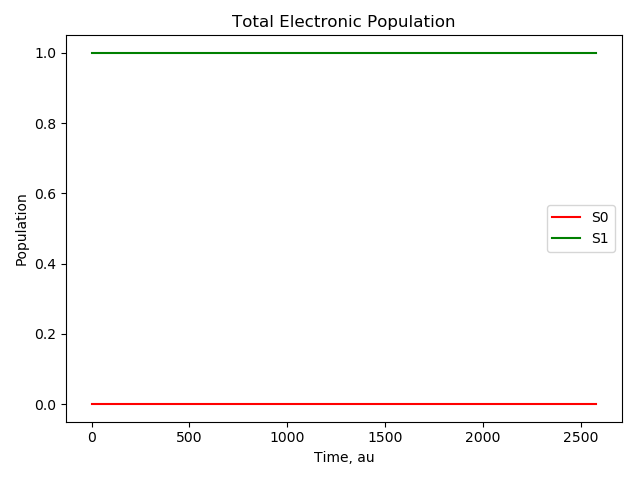

In [11]:
populated_states = np.amax(istates) + 1
traj_plot.plot_total_pop(times, mull_pop, populated_states, colors)

# Plotting Potential Energies

In [12]:
display(labels_to_plot_widget)

SelectMultiple(description=u'Trajectories', index=(0,), options=('00',), rows=10, value=('00',))

<IPython.core.display.Javascript object>


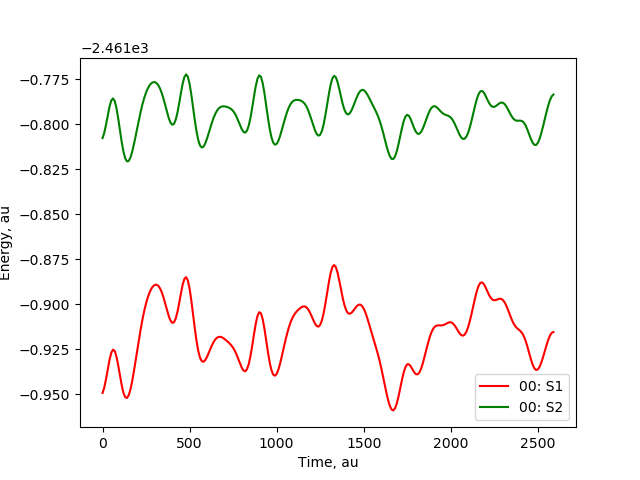

In [13]:
%matplotlib notebook
traj_plot.plot_energies(labels_to_plot_widget.value, time, poten, nstates, colors, linestyles)

# Plotting Energy gaps

In [14]:
display(labels_to_plot_widget)

SelectMultiple(description=u'Trajectories', index=(0,), options=('00',), rows=10, value=('00',))

<IPython.core.display.Javascript object>


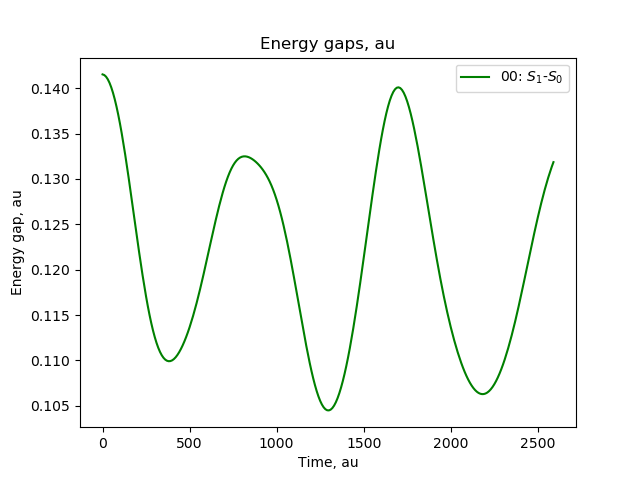

In [16]:
%matplotlib notebook
# Gap between ground and first excited states
state1 = 0
state2 = 1
# plot_e_gap(labels_to_plot_widget.value, time, poten, nstates, s1, s2)
traj_plot.plot_e_gap(time, poten, labels_to_plot_widget.value, state1, state2, istates_dict,
                     colors, linestyles, markers)

In [ ]:
%matplotlib notebook
spawnthresh = 0.00785
# plot_tdc(labels, time, tdc, nstates, spawnthresh)
traj_plot.plot_tdc(time, tdc, labels_to_plot_widget.value,
                   nstates, istates_dict, spawnthresh, colors, linestyles, markers)

# Trajectory visualization

In this widget we pick the trajectory label to visualize

In [17]:
xyz_widget = widgets.RadioButtons(
    options=labels,
#     value='pineapple',
    description='Trajectory:',
    disabled=False
)
display(xyz_widget)


RadioButtons(description=u'Trajectory:', options=('00',), value='00')

In [18]:
print "Trajectory:", xyz_widget.value
path_to_xyz = dir_name + "/traj_" + xyz_widget.value + ".xyz"
print "Path to xyz file:", path_to_xyz
traj = mda.Universe(path_to_xyz)
w = nv.show_mdanalysis(traj)
w

Trajectory: 00
Path to xyz file: /home/fedorovd/4tce/casscf_dynamics/traj_00.xyz


/home/fedorovd/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/fedorovd/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'resnames' Using default value of 'UNK'
  "".format(attrname, default))
/home/fedorovd/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/fedorovd/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/fedorovd/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(a

NGLWidget(count=260)